# Field Data Preprocessing
Author : Muhammad Iqbal Khatami

# 1. Load Library

In [117]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
from landmc.preprocessing import butter_filter, subsample, fk_transform
from pylops.basicoperators import *
import matplotlib.pyplot as plt

import cupy as cp
cp_asarray = cp.asarray
cp_asnumpy = cp.asnumpy

v_clip = 1e-2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Load Data

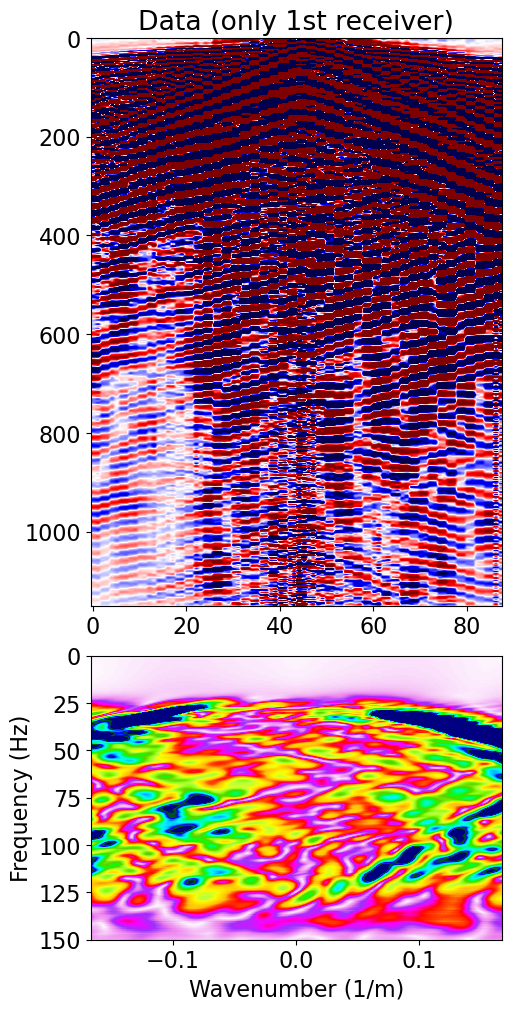

0.9787912599233475 -1.0


In [123]:
#Load data
file = np.load("../data/StrydeGradient.npz")
data = file['data'][:88,250:] 

#Time and space axis
x = file['x'][:88]
t = file['t'][250:]
#Cut time to t0
it_cut = np.where(t==0.6)[0][0]
data = data[:,:it_cut]
t=t[:it_cut]
t += -t[0]

nx,nt = data.shape
dx = x[1]-x[0]
dt = t[1]-t[0]

#Bandpass filter from 10 Hz (remove low-freq noise) to 140 Hz (maximum frequency of interest)
data = butter_filter(data,10,1/dt,mode='highpass')
data = butter_filter(data,140,1/dt,mode='lowpass')

#Scaling Data to be in the range of -1 to 1
sc = 1/np.max(np.abs(data)) 
data = sc*data

#Display
nfft_t, nfft_x = 2**12, 2**12
D, f, ks, Fop = fk_transform(data[::2], nfft_x, nfft_t, 2, dt) #F-K transform data

fig = plt.figure(constrained_layout=True, figsize=(5, 10))
axs = []
gs = fig.add_gridspec(3, 1)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[2, 0]))

axs[0].imshow(data.T,cmap='seismic',aspect='auto',vmin=-1e-3,vmax=1e-3)
axs[0].set_title("Data (only 1st receiver)")
axs[1].imshow(np.fft.fftshift(np.abs(D).T, axes=1), cmap='gist_ncar_r',aspect='auto',vmin=0,vmax=1e-2, 
           extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]))
axs[1].set_xlim(-1/(2*3), 1/(2*3))
axs[1].set_ylim(150,0)
axs[1].set_xlabel("Wavenumber (1/m)")
axs[1].set_ylabel("Frequency (Hz)")

plt.show()

print(data.max(),data.min())

# 3. Estimate Gradient

In [134]:
#Estimate first spatial gradient
D1op = FirstDerivative((nx,nt), axis=0,kind='forward',sampling=dx,order=5)
d1 = D1op * data
d1 = butter_filter(d1,10,1/dt,mode='highpass')
d1 = butter_filter(d1,140,1/dt,mode='lowpass')

#Removing the second receiver of each pair
iava = np.arange(0,nx,2)
d1 = d1[iava]
x_ = x[iava]
data_ = data[iava]
sc1 = np.max(np.abs(data)) / np.max(np.abs(d1_)) #Scaling factor for spatial gradient

dx_new = x_[1]-x_[0]
dx_new

nx = data.shape[0]
nt = data.shape[1]

D, f, ks, Fop = fk_transform(data_, nfft_x, nfft_t, dx_new, dt)
D1, f, ks, Fop = fk_transform(d1, nfft_x, nfft_t, dx_new, dt)

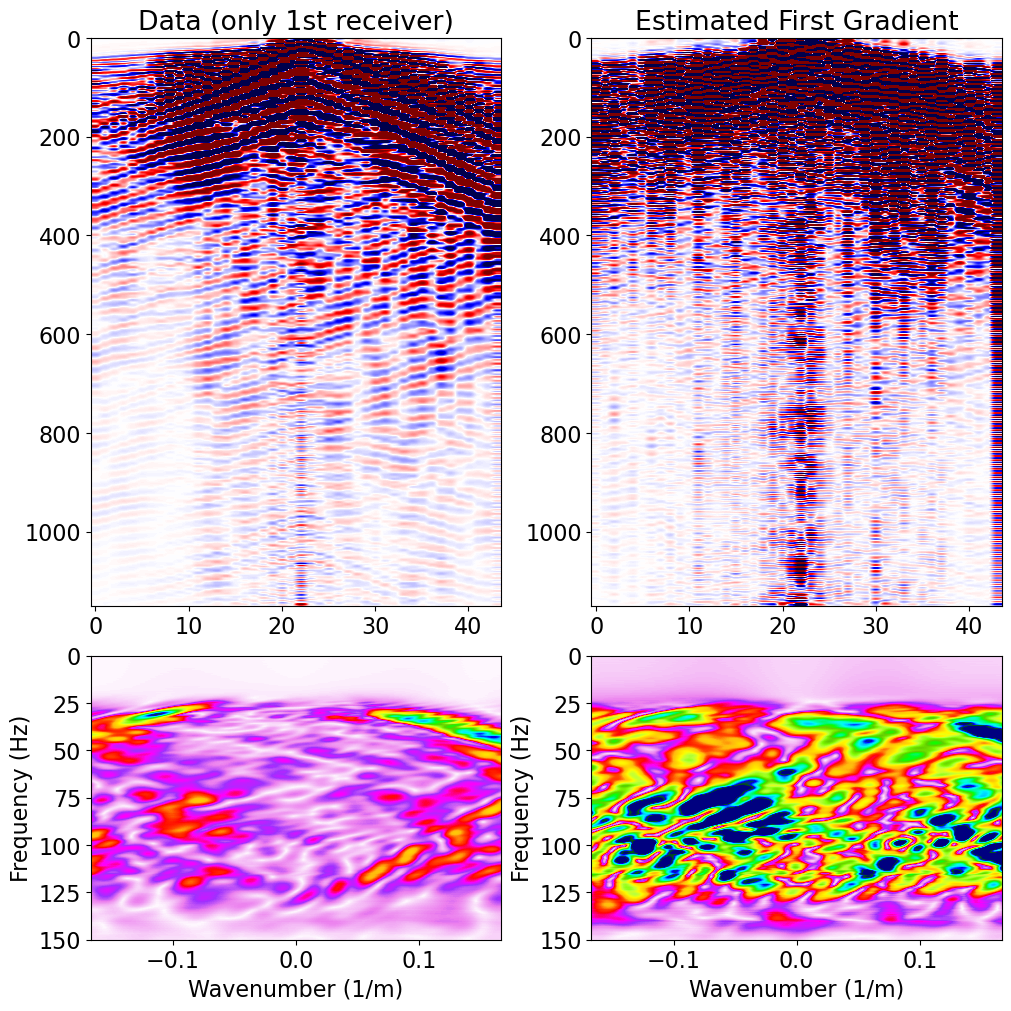

In [135]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
axs = []
gs = fig.add_gridspec(3, 2)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[2, 1]))

axs[0].imshow(data_.T,aspect='auto',vmin=-v_clip, vmax=v_clip,cmap='seismic')
axs[0].set_title("Data (only 1st receiver)")
axs[1].imshow(np.fft.fftshift(np.abs(D).T, axes=1), cmap='gist_ncar_r',aspect='auto',vmin=0,vmax=3e-2, 
           extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]))
axs[1].set_xlim(-1/(2*3), 1/(2*3))
axs[1].set_ylim(150,0)
axs[1].set_xlabel("Wavenumber (1/m)")
axs[1].set_ylabel("Frequency (Hz)")

axs[2].imshow(d1.T,aspect='auto',vmin=-v_clip, vmax=v_clip,cmap='seismic')
axs[2].set_title("Estimated First Gradient")
axs[3].imshow(np.fft.fftshift(np.abs(D1).T, axes=1), cmap='gist_ncar_r',aspect='auto',vmin=0,vmax=3e-2, 
           extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]))
axs[3].set_xlim(-1/(2*3), 1/(2*3))
axs[3].set_ylim(150,0)
axs[3].set_xlabel("Wavenumber (1/m)")
axs[3].set_ylabel("Frequency (Hz)")
plt.show()

In [136]:
np.savez("../data/StrydeGradient_preprocessed.npz", d1=d1.T, rec1=data_, x=x_,t=t,sc1=sc1)